In [479]:
import geopandas as gpd
import pandas as pd
import json
import osmnx as ox
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from shapely.geometry import Point
from shapely.ops import unary_union
import networkx as nx
from folium.plugins import HeatMap

Загружаем данные о доме с сайта ДОМ.РФ

In [480]:
base_url = "https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api"
test_id = "10199"

url_get_point_info = f"{base_url}/object/{test_id}"

In [481]:
with open("10199.json", "r", encoding="utf-8") as f:
    data = json.load(f)


In [482]:
data_relevant = data['data']

latitude = float(data_relevant['objLkLatitude'])
longitude = float(data_relevant['objLkLongitude'])
address = data_relevant['address']
floor_min = data_relevant['floorMin']
floor_max = data_relevant['floorMax']
wall_material = data_relevant['wallMaterialShortDesc']
parking_count = data_relevant['objElemParkingCnt']
class_desc = data_relevant['objLkClassDesc']

df = pd.DataFrame({
    'address': [address],
    'floor_min': [floor_min],
    'floor_max': [floor_max],
    'wall_material': [wall_material],
    'parking_count': [parking_count],
    'class_desc': [class_desc],
    'latitude': latitude,
    'longitude': longitude
})

gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_xy(df['longitude'], df['latitude']), crs=4326)

gdf.explore(tiles='cartodbpositron')

### Анализ текущей структуры землепользования по долям

In [483]:
place_name = "Лосиноостровский, Москва"

district = ox.geocode_to_gdf(place_name)

buildings = ox.features_from_place(place_name, tags={'building': True})
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]

landuse = ox.features_from_place(place_name, tags={'landuse': True})

In [484]:
data_crs = district.estimate_utm_crs()

# Перепроецируем данные 
district_utm = district.to_crs(data_crs)
buildings_utm = buildings.to_crs(data_crs)
landuse_utm = landuse.to_crs(data_crs)

In [485]:
area_district = district_utm.geometry.area
print(f"Площадь района: {round(area_district[0],2)} м²")
print(f"Площадь района: {round(area_district[0]/1000000,2)} км²")

Площадь района: 5368122.68 м²
Площадь района: 5.37 км²


In [486]:
buildings_utm['area'] = buildings_utm.geometry.area
buildings_area = buildings_utm['area'].sum()

#Смотрим на результат
print(f"Площадь застроенной территории: {round(buildings_area,2)} м²")
print(f"Площадь застроенной территории: {round(buildings_area/1000000,2)} км²")

Площадь застроенной территории: 626884.03 м²
Площадь застроенной территории: 0.63 км²


In [487]:
built_share = buildings_area * 100 / area_district

print(f"Площадь застроенной территории: {built_share[0]:.2f}%")

Площадь застроенной территории: 11.68%


In [488]:
landuse_utm['area'] = landuse_utm.geometry.area
summary = landuse_utm.groupby('landuse', as_index=False)['area'].sum()
summary['area_str'] = summary['area'].apply(lambda x: f"{x:,.0f} м²")


In [489]:
summary.sort_values('area', ascending=False)[['landuse', 'area_str']]


landuse      area_str
10        residential  2,713,903 м²
7             railway    845,880 м²
6          industrial    274,585 м²
4             garages    223,128 м²
1          brownfield    127,761 м²
2            cemetery    125,245 м²
5               grass    102,038 м²
3        construction     46,854 м²
11             retail     37,850 м²
0          allotments     27,904 м²
9           religious      8,315 м²
8   recreation_ground      5,247 м²

**Вывод**: Площадь застроенной террритори довольно небольшой - около 12% от площади района. 
В районе преобладает землепользование жилая застройка. На втором месте - Железнодорожная инфраструктура. На третьем - Индустриальная застройка и гаражные кооперативы. 

### Расчет обеспеченности населения инфраструктурой

Расчет населения района

In [490]:
df_pop = pd.read_csv('msk_mkd.csv', encoding='utf-8')
geometry = [Point(lon, lat) for lon, lat in zip(df_pop['lon'], df_pop['lat'])]
gdf_pop = gpd.GeoDataFrame(df_pop, geometry=geometry, crs='EPSG:4326')

In [491]:
assert gdf_pop.crs == district.crs
gdf_pop_district = gdf_pop.clip(district)

In [492]:
apartments = data_relevant.get('objFlatCnt', 0)
estimated_pop = apartments * 2.5 if apartments else floor_max * 4 * 2.5

print(f"Этажность: {floor_min}-{floor_max}")
print(f"Оценка населения: {estimated_pop:.0f} чел.")

# Добавляем наше новое здание в справочник зданий
my_building_row = pd.DataFrame({
    'address': [address],
    'lat': [latitude],
    'lon': [longitude],
    'estimated_population': [estimated_pop],
    'floors': [floor_max]
})
my_building_row = gpd.GeoDataFrame(my_building_row, geometry=[Point(longitude, latitude)], crs='EPSG:4326')
gdf_pop_district = pd.concat([gdf_pop_district, my_building_row], ignore_index=True)


Этажность: 2-23
Оценка населения: 3458 чел.


In [493]:
gdf_pop_district['area_residential_sum'] = gdf_pop_district.area_residential.sum()

In [494]:
gdf_pop_district['avg_area_per_person'] = gdf_pop_district['area_residential_sum'] / gdf_pop_district['DistrictPop']

In [495]:
gdf_pop_district['estimated_population'] = gdf_pop_district['area_residential'] / gdf_pop_district['avg_area_per_person']

Общественный транспорт (остановки)

In [496]:
gdf_stops = ox.features_from_place(
    query='Лосиноостровский район, Москва',
    tags={'public_transport': 'stop_position'}
).to_crs(data_crs)

In [497]:
gdf_stops.geom_type.value_counts()

Point    88
Name: count, dtype: int64

Школы

In [498]:
gdf_schools_all = ox.features_from_place(
        query = 'Лосиноостровский район, Москва',
        tags= {'amenity': 'school'}
    )

In [499]:
gdf_schools_all['geometry'] = gdf_schools_all.geometry.to_crs(data_crs).centroid

Детские сады

In [500]:
gdf_kinder_all = ox.features_from_place(
        query = 'Лосиноостровский район, Москва',
        tags= {'amenity': 'kindergarten'}
    )

In [501]:
gdf_kinder_points = gdf_kinder_all[gdf_kinder_all.geom_type == 'Point'].to_crs(data_crs).copy()
gdf_kinder_polygons = gdf_kinder_all[gdf_kinder_all.geom_type.isin(['Polygon', 'MultiPolygon'])].copy()
gdf_kinder_polygons['geometry'] = gdf_kinder_polygons.geometry.to_crs(data_crs).centroid

In [502]:
gdf_kinder_new = pd.concat([gdf_kinder_points, gdf_kinder_polygons], ignore_index=True)

Рассчитываем зоны доступности

In [503]:
graph = ox.graph_from_place('Лосиноостровский район, Москва', network_type='walk')
graph_proj = ox.project_graph(graph, to_crs=data_crs)

In [504]:
def get_nodes_within_distance(G, start_node, max_distance):
    """
    Находит все узлы в графе в пределах max_distance от start_node по дорожной сети.
    Использует алгоритм Дейкстры через NetworkX.
    """

    distances = nx.single_source_dijkstra_path_length(
        G, 
        start_node, 
        weight='length',  
        cutoff=max_distance 
    )
    return list(distances.keys())

Согласно п.11.24 СП 42.13330.2016 Дальность пешеходных подходов до ближайшей остановки общественного пассажирского транспорта допускается принимать не более 500 м;
Возьмем меньше, так как при таком расстоянии все 100% домов покрываются отсановками

In [505]:
transport_buffers = []
for idx, transport in gdf_stops.iterrows():
    transport_point = (transport.geometry.x, transport.geometry.y)
    nearest_node = ox.distance.nearest_nodes(graph_proj, transport_point[0], transport_point[1])
    accessible_nodes = get_nodes_within_distance(graph_proj, nearest_node, max_distance=250) 
    nodes_data = []
    for node in accessible_nodes:
        node_data = graph_proj.nodes[node]
        nodes_data.append(Point(node_data['x'], node_data['y']))
            
    nodes_gdf = gpd.GeoDataFrame(geometry=nodes_data, crs=data_crs)
            
    buffer_polygon = nodes_gdf.geometry.union_all().convex_hull
            
    transport_buffers.append(buffer_polygon)

In [506]:
gdf_transport_buffers = gpd.GeoDataFrame(geometry=transport_buffers, crs=data_crs)

In [507]:
school_buffers = []
for idx, school in gdf_schools_all.iterrows():
    school_point = (school.geometry.x, school.geometry.y)
    nearest_node = ox.distance.nearest_nodes(graph_proj, school_point[0], school_point[1])
    accessible_nodes = get_nodes_within_distance(graph_proj, nearest_node, max_distance=500) 
    nodes_data = []
    for node in accessible_nodes:
        node_data = graph_proj.nodes[node]
        nodes_data.append(Point(node_data['x'], node_data['y']))
            
    nodes_gdf = gpd.GeoDataFrame(geometry=nodes_data, crs=data_crs)
            
    buffer_polygon = nodes_gdf.geometry.union_all().convex_hull
            
    school_buffers.append(buffer_polygon)

In [508]:
gdf_school_buffers = gpd.GeoDataFrame(geometry=school_buffers, crs=data_crs)

In [509]:
kinder_buffers = []
for idx, kinder in gdf_kinder_new.iterrows():
    kinder_point = (kinder.geometry.x, kinder.geometry.y)
    nearest_node = ox.distance.nearest_nodes(graph_proj, kinder_point[0], kinder_point[1])
    accessible_nodes = get_nodes_within_distance(graph_proj, nearest_node, max_distance=300) 
    nodes_data = []
    for node in accessible_nodes:
        node_data = graph_proj.nodes[node]
        nodes_data.append(Point(node_data['x'], node_data['y']))
            
    nodes_gdf = gpd.GeoDataFrame(geometry=nodes_data, crs=data_crs)
            
    buffer_polygon = nodes_gdf.geometry.union_all().convex_hull
            
    kinder_buffers.append(buffer_polygon)

In [510]:
gdf_kinder_buffers = gpd.GeoDataFrame(geometry=kinder_buffers, crs=data_crs)

In [511]:
gdf_transport_buffers = gdf_transport_buffers.to_crs(gdf_pop_district.crs)
gdf_school_buffers = gdf_school_buffers.to_crs(gdf_pop_district.crs)
gdf_kinder_buffers = gdf_kinder_buffers.to_crs(gdf_pop_district.crs)
transport_zone = unary_union(gdf_transport_buffers)
school_zone = unary_union(gdf_school_buffers)
kinder_zone = unary_union(gdf_kinder_buffers)

In [512]:
gdf_pop_district['in_transport'] = gdf_pop_district.within(transport_zone)
gdf_pop_district['in_school'] = gdf_pop_district.within(school_zone)
gdf_pop_district['in_kinder'] = gdf_pop_district.within(kinder_zone)

In [513]:
categories = {
    'И школы, и детские сады': gdf_pop_district[(gdf_pop_district['in_school']) & (gdf_pop_district['in_kinder'])],
    'Только школы': gdf_pop_district[(gdf_pop_district['in_school']) & (~gdf_pop_district['in_kinder'])],
    'Только детские сады': gdf_pop_district[(~gdf_pop_district['in_school']) & (gdf_pop_district['in_kinder'])],
    'Вне зон доступности': gdf_pop_district[(~gdf_pop_district['in_school']) & (~gdf_pop_district['in_kinder'])]
}
pop_counts = {cat: categories[cat]['estimated_population'].sum() for cat in categories}

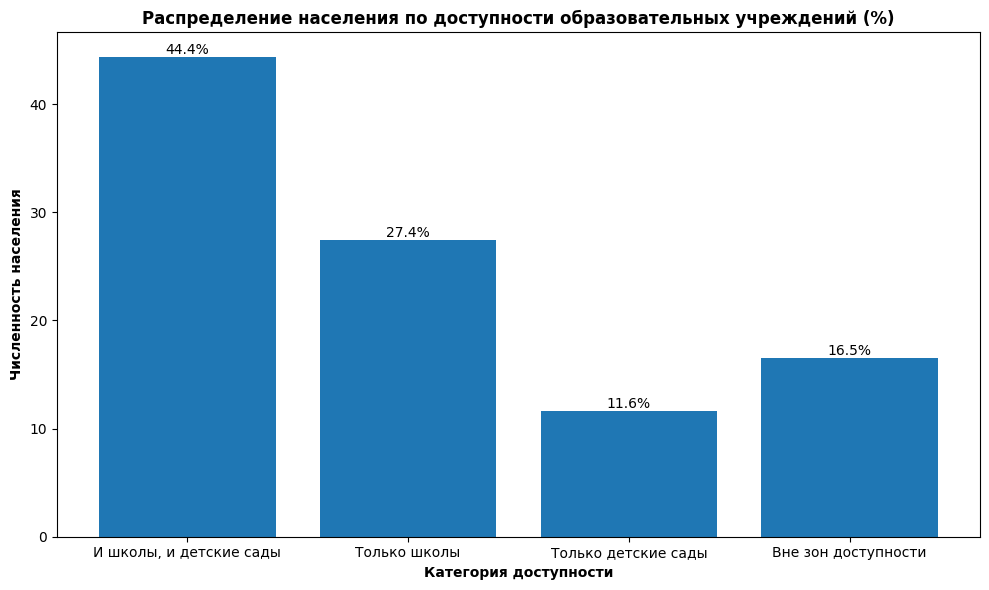

In [514]:
total_population = sum(pop_counts.values())
pop_percentages = {cat: (count * 100 / total_population) for cat, count in pop_counts.items()}

fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(pop_counts.keys(), pop_percentages.values())
for bar, pct in zip(bars, pop_percentages.values()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=10)
plt.xlabel('Категория доступности', fontweight='bold')
plt.ylabel('Численность населения', fontweight='bold')
plt.title('Распределение населения по доступности образовательных учреждений (%)', fontweight='bold')
plt.tight_layout()

In [515]:
gdf_pop_district['category'] = gdf_pop_district.apply(
    lambda row: 'И школы, и детские сады' if (row['in_school'] and row['in_kinder']) 
    else 'Только школы' if row['in_school'] 
    else 'Только детские сады' if row['in_kinder'] 
    else 'Вне зон доступности', axis=1
)

In [516]:
categories_transport = {
    'В зоне транспортной доступности': gdf_pop_district[gdf_pop_district['in_transport']],
    'Вне зоны транспортной доступности': gdf_pop_district[~gdf_pop_district['in_transport']]
}
pop_counts_transport = {cat: categories_transport[cat]['estimated_population'].sum() for cat in categories_transport}

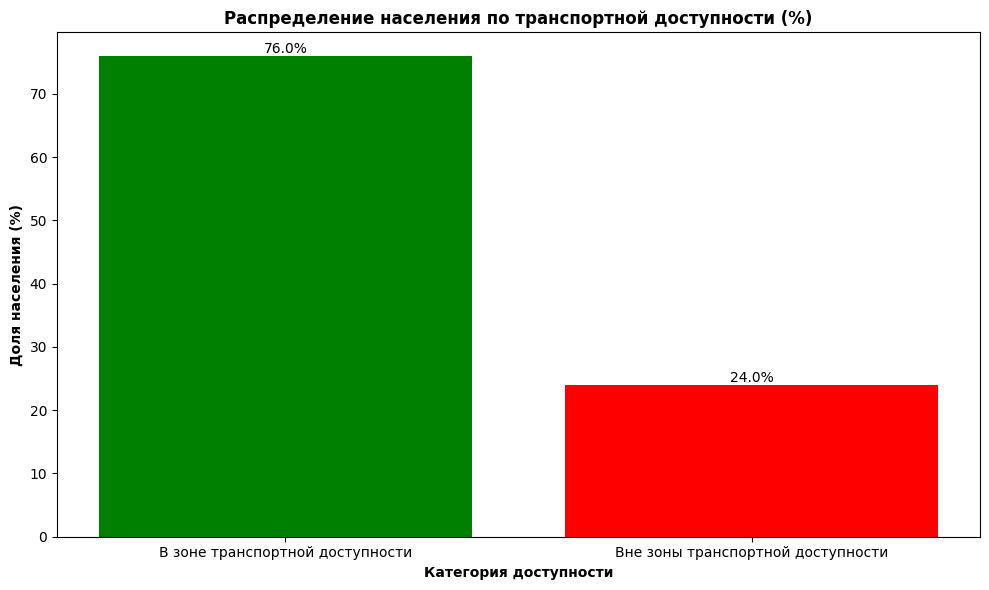

In [517]:
total_population_transport = sum(pop_counts_transport.values())
pop_percentages_transport = {cat: (count * 100 / total_population_transport) for cat, count in pop_counts_transport.items()}

fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(pop_counts_transport.keys(), pop_percentages_transport.values(), color=['green', 'red'])
for bar, pct in zip(bars, pop_percentages_transport.values()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=10)
plt.xlabel('Категория доступности', fontweight='bold')
plt.ylabel('Доля населения (%)', fontweight='bold')
plt.title('Распределение населения по транспортной доступности (%)', fontweight='bold')
plt.tight_layout()

In [518]:
gdf_pop_district['category_transport'] = gdf_pop_district['in_transport'].apply(
    lambda x: 'В зоне транспортной доступности' if x else 'Вне зоны транспортной доступности'
)

**Выводы:** Большая часть зданий Лосиноостровского район расположена в зоне досягаемости школ и детских садов. Также 76% зданий находятся в зоне досягаемости транспорта. Целевой дом имеет рядом остановки, но рядом с ним не расположены школы / деские сады.

### Высоты зданий 

Пробовал скачать данные отсюда по тайлу МСК (e035_n60_e040_n55.zip), но загрузка около 3 часов, поэтому взял расчетный вариант

In [519]:
buildings['levels'] = pd.to_numeric(buildings.get('building:levels'), errors='coerce')
buildings_with_levels = buildings[buildings['levels'].notna()].copy()

# Оценка высоты: ~3м на этаж
buildings_with_levels['est_height'] = buildings_with_levels['levels'] * 3

print(f"Зданий с данными об этажности: {len(buildings_with_levels)}")
if len(buildings_with_levels) > 0:
    print(f"Средняя этажность: {buildings_with_levels['levels'].mean():.1f}")
    print(f"Максимальная этажность: {buildings_with_levels['levels'].max():.0f}")
    print(f"Средняя высота (оценка): {buildings_with_levels['est_height'].mean():.1f} м")
    print(f"Максимальная высота (оценка): {buildings_with_levels['est_height'].max():.0f} м")

centroids = buildings_with_levels.geometry.centroid
heat_data = [[c.y, c.x, float(h)] for c, h in zip(centroids, buildings_with_levels['est_height'])]

Зданий с данными об этажности: 590
Средняя этажность: 5.3
Максимальная этажность: 24
Средняя высота (оценка): 16.0 м
Максимальная высота (оценка): 72 м


/var/folders/1k/dlb71g3j1791n0d5frts_ccr0000gn/T/ipykernel_71394/2312628208.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings_with_levels.geometry.centroid


### Финальная карта

In [520]:
landuse_colors = {
    'residential': '#FFD700',
    'industrial': '#8B4513',
    'commercial': '#FF6347',
    'retail': '#FF69B4',
    'railway': '#708090',
    'cemetery': '#556B2F',
    'grass': '#90EE90',
    'forest': '#228B22',
    'garages': '#A9A9A9',
    'construction': '#FFA500',
    'brownfield': '#D2691E',
    'allotments': '#9ACD32',
    'recreation_ground': '#32CD32',
    'religious': '#9370DB'
}

In [521]:
m = folium.Map(
    location=[latitude, longitude], 
    zoom_start=14,
    tiles=None
)

folium.TileLayer('cartodbpositron', name='CartoDB Positron').add_to(m)
folium.TileLayer('OpenStreetMap', name='OpenStreetMap').add_to(m)
folium.TileLayer('cartodbdark_matter', name='CartoDB Dark').add_to(m)

# Базовые слои
folium.GeoJson(district, name='Границы района',
    style_function=lambda x: {'fillColor': '#3388ff', 'color': '#3388ff', 'weight': 2, 'fillOpacity': 0.1}
).add_to(m)

folium.GeoJson(buildings, name='Здания',
    style_function=lambda x: {'fillColor': '#ff7800', 'color': '#ff7800', 'weight': 1, 'fillOpacity': 0.5}
).add_to(m)

folium.GeoJson(landuse, name='Землепользование',
    style_function=lambda x: {
        'fillColor': landuse_colors.get(x['properties'].get('landuse'), '#228B22'),
        'color': '#333', 'weight': 1, 'fillOpacity': 0.6
    },
    tooltip=folium.GeoJsonTooltip(fields=['landuse'], aliases=['Тип:']),
    popup=folium.GeoJsonPopup(fields=['landuse', 'name'], aliases=['Тип землепользования:', 'Название:'])
).add_to(m)

folium.Marker([latitude, longitude],
    popup=f"<b>{address}</b><br>Этажей: {floor_min}-{floor_max}<br>Материал стен: {wall_material}",
    icon=folium.Icon(color='red', icon='home')
).add_to(m)

# Образовательная доступность (выключена по умолчанию)
population_group = folium.FeatureGroup(name='Доступность образовательных учреждений', show=False)

colors = {
    'И школы, и детские сады': 'green',
    'Только школы': 'purple',
    'Только детские сады': 'orange',
    'Вне зон доступности': 'red'
}

for idx, row in gdf_pop_district.iterrows():
    popup_html = f"""
    <div style="font-family: Arial; width: 400px; font-size: 14px; padding: 10px;">
        <p><b>📍 Адрес:</b> {row.get('address', 'N/A')}</p>
        <p><b>👥 Население:</b> {row.get('estimated_population', 0):.0f} чел.</p>
        <p><b>🏫 В зоне школ:</b> {'✓ Да' if row['in_school'] else '✗ Нет'}</p>
        <p><b>🏠 В зоне детских садов:</b> {'✓ Да' if row['in_kinder'] else '✗ Нет'}</p>
    </div>
    """
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5, popup=folium.Popup(popup_html, max_width=350),
        color=colors[row['category']], fillOpacity=0.7
    ).add_to(population_group)

population_group.add_to(m)

# Транспортная доступность (выключена по умолчанию)
transport_group = folium.FeatureGroup(name='Транспортная доступность', show=False)

colors_transport = {
    'В зоне транспортной доступности': 'blue',
    'Вне зоны транспортной доступности': 'gray'
}

for idx, row in gdf_pop_district.iterrows():
    popup_html = f"""
    <div style="font-family: Arial; width: 400px; font-size: 14px; padding: 10px;">
        <p><b>📍 Адрес:</b> {row.get('address', 'N/A')}</p>
        <p><b>👥 Население:</b> {row.get('estimated_population', 0):.0f} чел.</p>
        <p><b>🚌 Транспорт:</b> {'✓ Да' if row['in_transport'] else '✗ Нет'}</p>
    </div>
    """
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5, popup=folium.Popup(popup_html, max_width=350),
        color=colors_transport[row['category_transport']], fillOpacity=0.7
    ).add_to(transport_group)

transport_group.add_to(m)

height_group = folium.FeatureGroup(name='Высотность зданий (HeatMap)', show=False)
HeatMap(
    heat_data, 
    radius=20, 
    blur=15, 
    max_zoom=17,
    gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'yellow', 0.8: 'orange', 1: 'red'}
).add_to(height_group)
height_group.add_to(m)

folium.LayerControl().add_to(m)

legend_js = """
<div id="legend-education" style="display:none; position: fixed; bottom: 30px; right: 10px; width: 280px; 
     background-color: white; border:2px solid #333; z-index:9999; padding: 15px; border-radius: 8px;">
     <b>Образование:</b>
     <div><span style="display:inline-block;width:14px;height:14px;border:3px solid green;border-radius:50%;"></span> И школы, и детские сады</div>
     <div><span style="display:inline-block;width:14px;height:14px;border:3px solid purple;border-radius:50%;"></span> Только школы</div>
     <div><span style="display:inline-block;width:14px;height:14px;border:3px solid orange;border-radius:50%;"></span> Только детские сады</div>
     <div><span style="display:inline-block;width:14px;height:14px;border:3px solid red;border-radius:50%;"></span> Вне зон доступности</div>
</div>
<div id="legend-transport" style="display:none; position: fixed; bottom: 30px; right: 10px; width: 280px; 
     background-color: white; border:2px solid #333; z-index:9999; padding: 15px; border-radius: 8px;">
     <b>Транспорт:</b>
     <div><span style="display:inline-block;width:14px;height:14px;border:3px solid blue;border-radius:50%;"></span> В зоне доступности</div>
     <div><span style="display:inline-block;width:14px;height:14px;border:3px solid gray;border-radius:50%;"></span> Вне зоны доступности</div>
</div>
<script>
document.addEventListener('DOMContentLoaded', function() {
    var map = document.querySelector('.folium-map');
    var observer = new MutationObserver(function() {
        var eduLayer = document.querySelector('input[type="checkbox"] + span:contains("образовательных")') || 
                       Array.from(document.querySelectorAll('.leaflet-control-layers-overlays label')).find(l => l.textContent.includes('образовательных'));
        var transLayer = Array.from(document.querySelectorAll('.leaflet-control-layers-overlays label')).find(l => l.textContent.includes('Транспортная'));
        
        if(eduLayer) {
            var eduCheckbox = eduLayer.querySelector('input') || eduLayer.previousElementSibling;
            if(eduCheckbox) eduCheckbox.addEventListener('change', function() {
                document.getElementById('legend-education').style.display = this.checked ? 'block' : 'none';
            });
        }
        if(transLayer) {
            var transCheckbox = transLayer.querySelector('input') || transLayer.previousElementSibling;
            if(transCheckbox) transCheckbox.addEventListener('change', function() {
                document.getElementById('legend-transport').style.display = this.checked ? 'block' : 'none';
            });
        }
    });
    setTimeout(function() {
        var labels = document.querySelectorAll('.leaflet-control-layers-overlays label');
        labels.forEach(function(label) {
            var checkbox = label.querySelector('input');
            if(label.textContent.includes('образовательных') && checkbox) {
                checkbox.addEventListener('change', function() {
                    document.getElementById('legend-education').style.display = this.checked ? 'block' : 'none';
                });
            }
            if(label.textContent.includes('Транспортная') && checkbox) {
                checkbox.addEventListener('change', function() {
                    document.getElementById('legend-transport').style.display = this.checked ? 'block' : 'none';
                });
            }
        });
    }, 1000);
});
</script>
"""
m.get_root().html.add_child(folium.Element(legend_js))

height_group.add_to(m)

m.save('index.html')

In [522]:
m